Gradient Boosting Models (e.g., XGBoost, LightGBM)

Generalized Additive Models (GAM) 

Support Vector Regression (SVR) 

Convolutional Neural Networks (CNN) 

Recurrent Neural Networks (RNN) 

Long Short-Term Memory Networks (LSTM) 

Transformer-based Models


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('./solar_weather_processed.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196776 entries, 0 to 196775
Data columns (total 27 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Energy delta[Wh]  196776 non-null  float64
 1   GHI               196776 non-null  float64
 2   temp              196776 non-null  float64
 3   pressure          196776 non-null  float64
 4   humidity          196776 non-null  float64
 5   wind_speed        196776 non-null  float64
 6   rain_1h           196776 non-null  float64
 7   snow_1h           196776 non-null  float64
 8   clouds_all        196776 non-null  float64
 9   isDayTime         196776 non-null  int64  
 10  Year              196776 non-null  int64  
 11  Month_num         196776 non-null  int64  
 12  DayOfYear         196776 non-null  int64  
 13  Minute            196776 non-null  int64  
 14  Hour              196776 non-null  int64  
 15  Hour_sin          196776 non-null  float64
 16  Hour_cos          19

# Seperate file for model buiding only


In [5]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error


In [6]:
# 6. Define X (features) and y (target)
FEATURES = [col for col in df.columns if col != 'Energy delta[Wh]']
X = df[FEATURES]
y = df['Energy delta[Wh]']

In [7]:
# 7. Time-based train-test split (80-20)
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

## Checking feature importance

         Feature  Importance
24  Energy_lag_1    0.677571
0            GHI    0.404244
17      Week_cos    0.019930
13          Hour    0.016298
25  Energy_lag_2    0.012857
11     DayOfYear    0.003137
7     clouds_all    0.002597
1           temp    0.001564
9           Year    0.001364
5        rain_1h    0.001198
4     wind_speed    0.001113
15      Hour_cos    0.001036
3       humidity    0.000960
12        Minute    0.000808
2       pressure    0.000585
16      Week_sin    0.000445
22    Season_sin    0.000394
14      Hour_sin    0.000328
18    Minute_sin    0.000127
10     Month_num    0.000071
23    Season_cos    0.000071
19    Minute_cos    0.000039
8      isDayTime    0.000000
6        snow_1h    0.000000
20   Weekday_sin    0.000000
21   Weekday_cos    0.000000


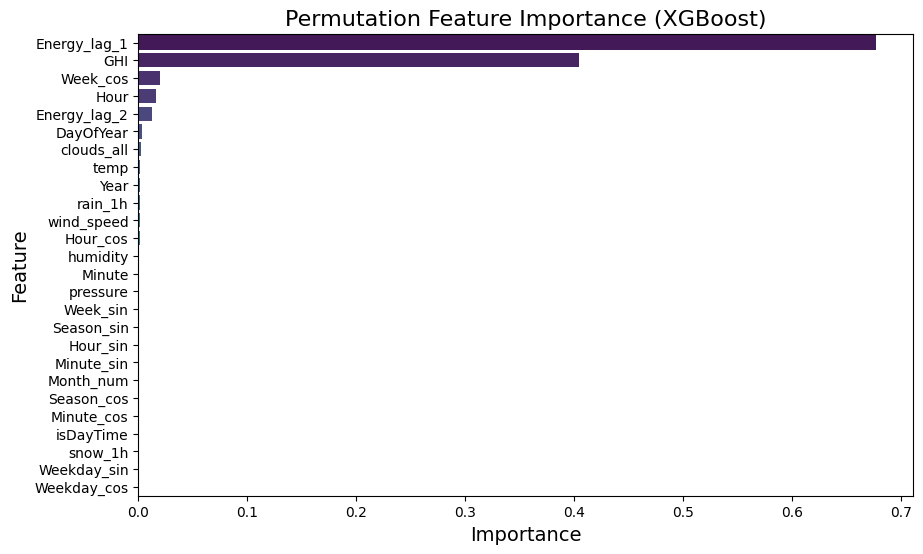

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


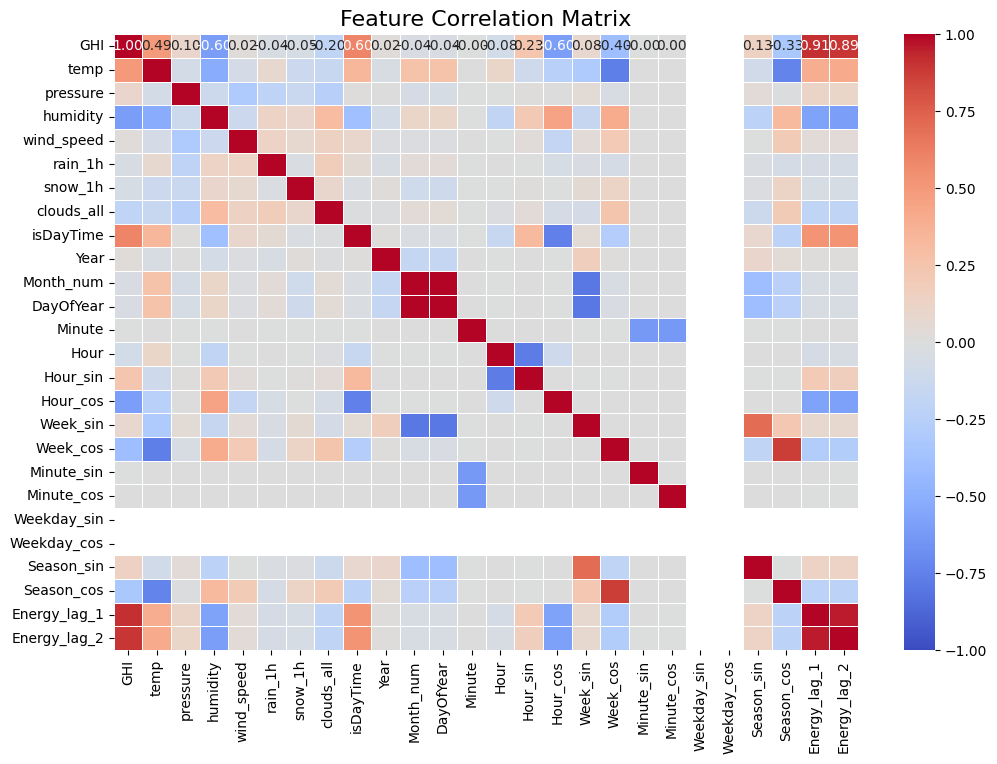

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance

# Assuming X_train and y_train are already defined
# 1️ Train the XGBoost Model
model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# 2️ Compute Permutation Feature Importance
perm_importance = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)

# 3️ Convert Results to DataFrame
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)

# 4️ Display Important Features
print(feature_importance)

# 5 Visualize Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance, palette="viridis")
plt.title("Permutation Feature Importance (XGBoost)", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.show()

# 6 Compute and Visualize Correlation Matrix
plt.figure(figsize=(12, 8))
corr_matrix = X_train.corr()  # Compute correlation matrix
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Feature Correlation Matrix", fontsize=16)
plt.show()

### SHAP Importance checking

100%|===================| 157418/157420 [14:14<00:00]        

         Feature  Importance
24  Energy_lag_1    0.089097
0            GHI    0.061509
13          Hour    0.007689
17      Week_cos    0.007258
25  Energy_lag_2    0.003465
11     DayOfYear    0.003156
7     clouds_all    0.002785
1           temp    0.001105
22    Season_sin    0.000896
5        rain_1h    0.000867
9           Year    0.000824
12        Minute    0.000802
3       humidity    0.000643
14      Hour_sin    0.000634
15      Hour_cos    0.000618
16      Week_sin    0.000581
4     wind_speed    0.000541
10     Month_num    0.000502
2       pressure    0.000374
18    Minute_sin    0.000237
19    Minute_cos    0.000108
23    Season_cos    0.000088
8      isDayTime    0.000000
20   Weekday_sin    0.000000
21   Weekday_cos    0.000000
6        snow_1h    0.000000


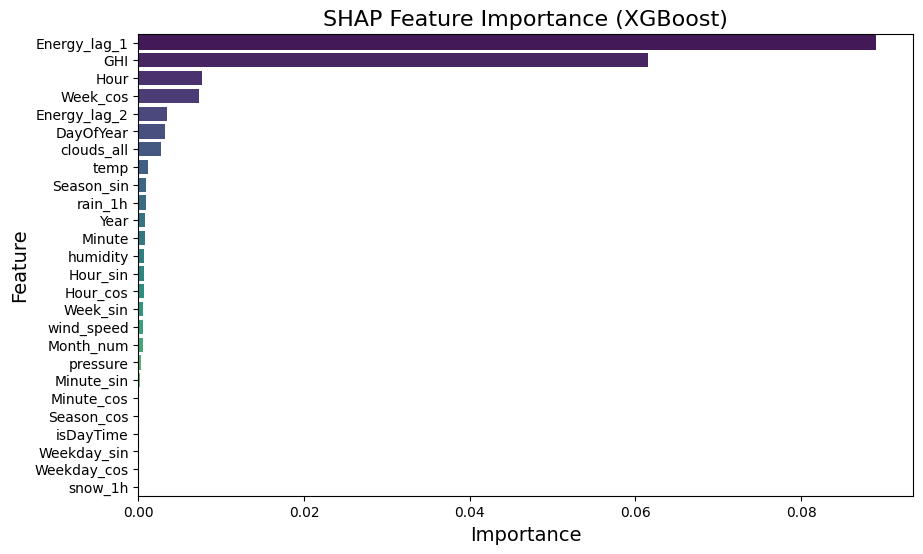

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


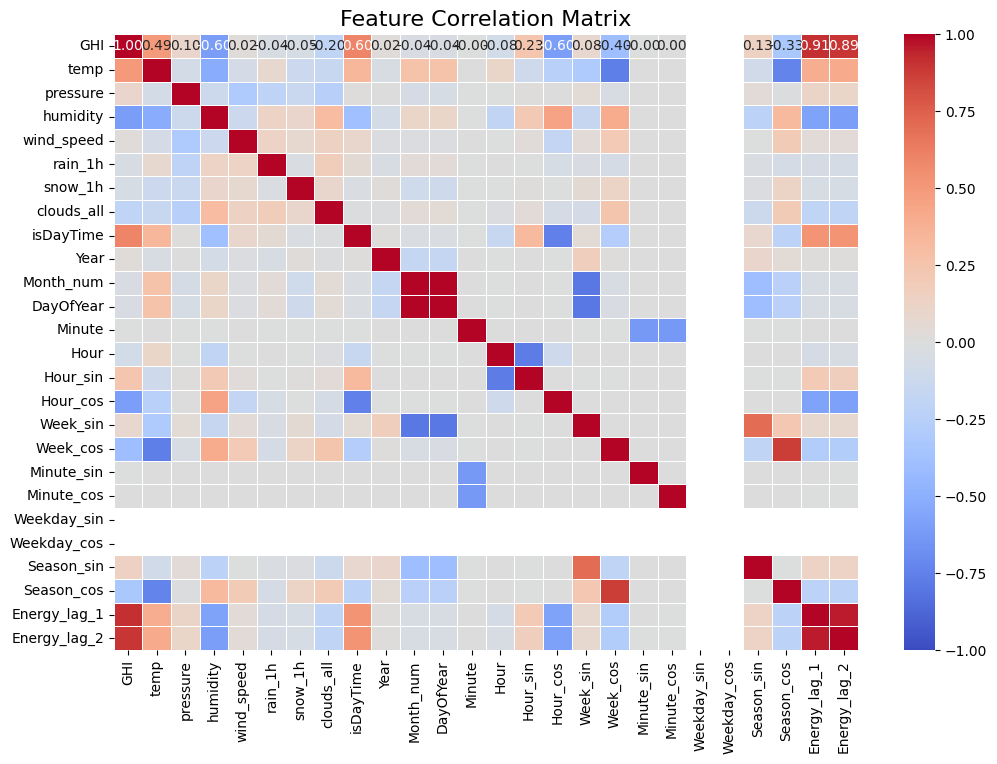

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from xgboost import XGBRegressor

# 1️⃣ Train the XGBoost Model
model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# 2️⃣ Compute SHAP Values
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

# 3️⃣ Compute Mean Absolute SHAP Value for Each Feature
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": np.abs(shap_values.values).mean(axis=0)  # Taking mean absolute SHAP values
}).sort_values(by="Importance", ascending=False)

# 4️⃣ Display Important Features
print(feature_importance)

# 5️⃣ Visualize SHAP Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance, palette="viridis")
plt.title("SHAP Feature Importance (XGBoost)", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.show()

# 6️⃣ Compute and Visualize Correlation Matrix
plt.figure(figsize=(12, 8))
corr_matrix = X_train.corr()  # Compute correlation matrix
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Feature Correlation Matrix", fontsize=16)
plt.show()


 Recommendation:
 
Start with the top 5 features (Importance > 0.01) and evaluate performance.

If performance drops, gradually add more features until it stabilizes.

Avoid including features with near-zero importance (e.g., isDayTime, snow_1h, Weekday_sin), as they add noise.

# Forward Feature Selection(using xgboost as baseline)

Tier	Importance Range	Features
Tier 1 (Critical)	> 0.4	Energy_lag_1 (0.677), GHI (0.404)

Tier 2 (Moderate)	0.01–0.4	Week_cos (0.019), Hour (0.016), Energy_lag_2 (0.012)

Tier 3 (Low)	0.001–0.01	DayOfYear, clouds_all, temp, rain_1h, wind_speed, Hour_cos, humidity, Minute

Tier 4 (Near-Zero)	< 0.001	pressure, Week_sin, Season_sin, Hour_sin, Minute_sin, Month_num, Season_cos, etc.

Tier 5 (Zero)	0.0	isDayTime, snow_1h, Weekday_sin, Weekday_cos （dropped)

By default we accept the top 5 importance

## Models

### XGboost, ligbtGBM

MAE: 0.01977369171926068
RMSE: 0.04993535928348696


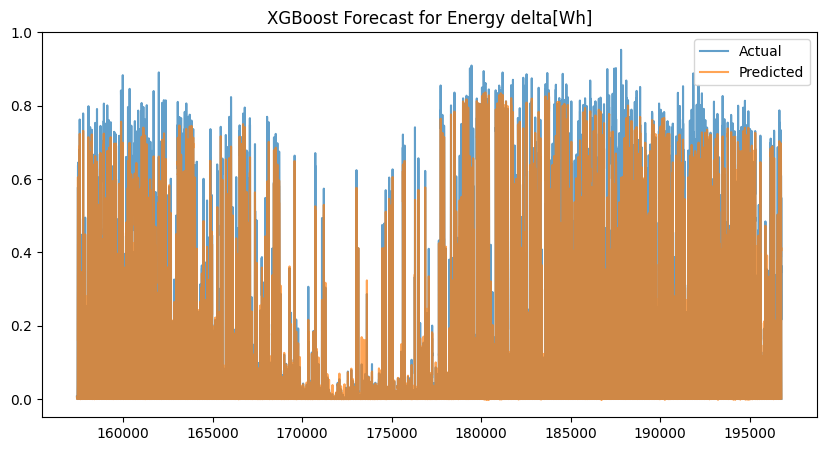

In [10]:
# 8. Train XGBoost
model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_test, y_test)], 
          verbose=False)

# 9. Predict
y_pred = model.predict(X_test)

# 10. Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("RMSE:", rmse)

# 11. Plot
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.7)
plt.title("XGBoost Forecast for Energy delta[Wh]")
plt.legend()
plt.show()


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2220
[LightGBM] [Info] Number of data points in the train set: 157420, number of used features: 24
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.112938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

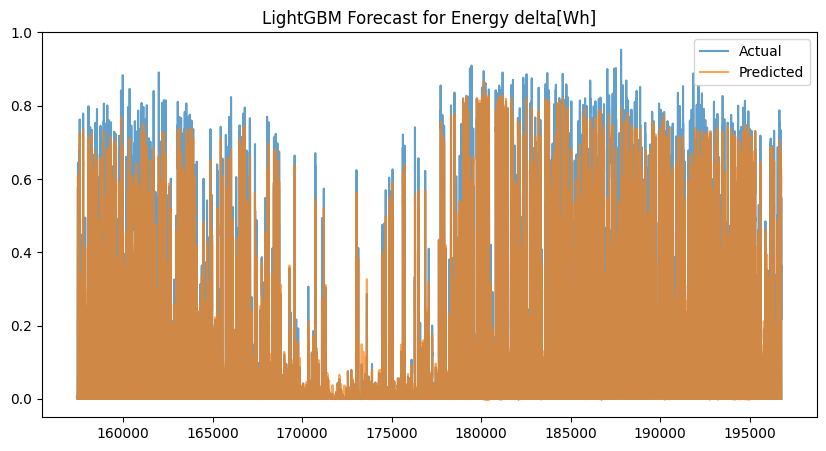

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 8. Train LightGBM
model = LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_test, y_test)])  # Corrected parameter

# 9. Predict
y_pred = model.predict(X_test)

# 10. Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)

# 11. Plot
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.7)
plt.title("LightGBM Forecast for Energy delta[Wh]")
plt.legend()
plt.show()


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2220
[LightGBM] [Info] Number of data points in the train set: 157420, number of used features: 24
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.112938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

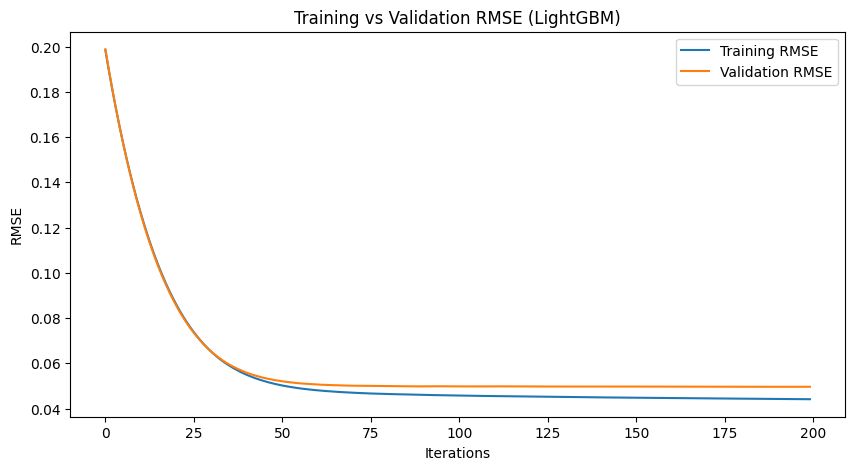

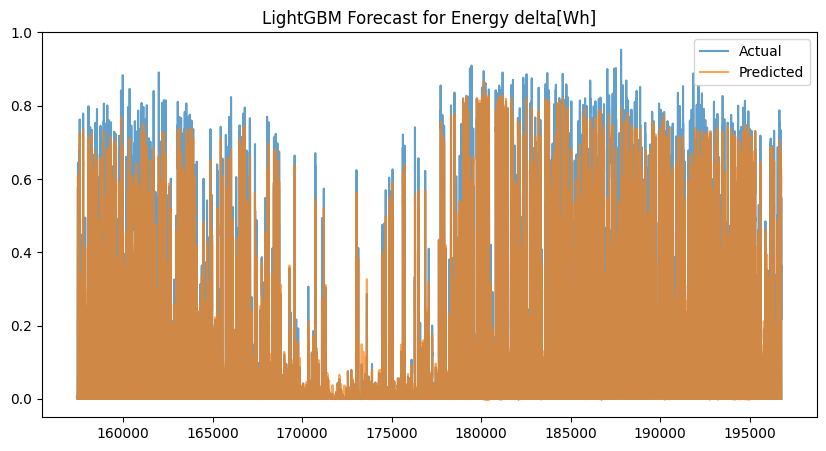

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor, early_stopping, record_evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 8. Train LightGBM with monitoring
model = LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)

evals_result = {}  # Dictionary to store training history

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric="rmse",  # Use RMSE for evaluation
    callbacks=[record_evaluation(evals_result)]  # ✅ Fix: Store training history
)

# 9. Predict
y_pred = model.predict(X_test)

# 10. Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("RMSE:", rmse)

# 11. Plot Training Curve (to check overfitting)
plt.figure(figsize=(10, 5))
plt.plot(evals_result["training"]["rmse"], label="Training RMSE")  # ✅ Fix: "training" is now recorded
plt.plot(evals_result["valid_1"]["rmse"], label="Validation RMSE")
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.title("Training vs Validation RMSE (LightGBM)")
plt.legend()
plt.show()

# 12. Plot Predictions vs Actual
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.7)
plt.title("LightGBM Forecast for Energy delta[Wh]")
plt.legend()
plt.show()


### GAM

In [13]:
import pandas as pd
from pygam import LinearGAM, s

In [14]:

# Define GAM model with smooth terms for each feature
from pygam import LinearGAM, s

# Define GAM model with smooth terms for each feature
gam = LinearGAM(
    s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + 
    s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + 
    s(16) + s(17) + s(18) + s(19) + s(20) + s(21)
).fit(X, y)

# Print model summary
print(gam.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    223.9474
Link Function:                     IdentityLink Log Likelihood:                             -17089305.8949
Number of Samples:                       196776 AIC:                                         34179061.6845
                                                AICc:                                        34179062.2017
                                                GCV:                                                0.0055
                                                Scale:                                              0.0055
                                                Pseudo R-Squared:                                   0.8736
Feature Function                  Lam

C:\Users\User\AppData\Local\Temp\ipykernel_2208\1510671690.py:12: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predict on test set
y_pred = gam.predict(X_test)

# Compute accuracy metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = (abs(y_test - y_pred) / y_test).mean() * 100

# Print results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


MAE: 0.0469
MSE: 0.0062
RMSE: 0.0789
MAPE: inf%


### SVR

In [16]:
from sklearn.svm import SVR


In [17]:


# 4. Define and Train SVR Model
svr = SVR(kernel='rbf', C=10, epsilon=0.01)  # RBF kernel is good for nonlinear relationships
svr.fit(X_train, y_train)

# 5. Make Predictions
y_pred = svr.predict(X_test)

# 6. Evaluate the Model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = (abs(y_test - y_pred) / y_test).mean() * 100

# 7. Print Performance Metrics
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

MAE: 0.0775
MSE: 0.0231
RMSE: 0.1519
MAPE: inf%


### CNN

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


# 3. Normalize Data (CNNs work better with scaled inputs)
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.to_numpy().reshape(-1, 1))

# 4. Reshape Data for CNN [Samples, Time Steps, Features]
TIME_STEPS = 10  # Number of previous time steps to use for prediction

def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, TIME_STEPS)

# 5. Build CNN Model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(TIME_STEPS, X_train.shape[1])),
    Dropout(0.2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# 6. Train the Model
history = model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, validation_data=(X_test_seq, y_test_seq), verbose=1)

# 7. Make Predictions
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# 8. Evaluate the Model
mae = mean_absolute_error(y_test_seq, y_pred)
mse = mean_squared_error(y_test_seq, y_pred)
rmse = np.sqrt(mse)
mape = (abs(y_test_seq - y_pred) / y_test_seq).mean() * 100

# 9. Print Performance Metrics
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


Epoch 1/20


C:\Users\User\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4920/4920 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0074 - val_loss: 0.0041
Epoch 2/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 3/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 4/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0039 - val_loss: 0.0044
Epoch 5/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 6/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 7/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 8/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 9/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 10/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 11/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 12/20
4920/4920 ━━━━━━━━━━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_2208\1712566322.py:53: RuntimeWarning: divide by zero encountered in divide
  mape = (abs(y_test_seq - y_pred) / y_test_seq).mean() * 100


### LSTM

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 3. Normalize Data (LSTMs work better with scaled inputs)
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# 4. Reshape Data for LSTM [Samples, Time Steps, Features]
TIME_STEPS = 10  # Number of previous time steps to use for prediction

def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, TIME_STEPS)

# 5. Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(TIME_STEPS, X_train.shape[1])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# 6. Train the Model
history = model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, validation_data=(X_test_seq, y_test_seq), verbose=1)

# 7. Make Predictions
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# 8. Evaluate the Model
mae = mean_absolute_error(y_test_seq, y_pred)
mse = mean_squared_error(y_test_seq, y_pred)
rmse = root_mean_squared_error(y_test_seq, y_pred)
mape = (abs(y_test_seq - y_pred) / y_test_seq).mean() * 100

# 9. Print Performance Metrics
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
 

AttributeError: 'Series' object has no attribute 'reshape'